# Temp Analysis Luki

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
sns.set_theme()

In [4]:
TEMP_PROCESSED_FOLDER = 'data/processed/temperature/'
TEMP_GLOBAL_FILE = 'temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'temp-land-region.csv'
TEMP_COUNTRY_FILE = 'temp-land-country.csv'

In [5]:
temp_global = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_COUNTRY_FILE)

Group yearly

In [6]:
temp_global_yearly = temp_global.groupby(["year"])["temperature_anomaly"].mean()
temp_global_yearly = temp_global_yearly.reset_index()
temp_country_yearly = temp_country.groupby(["year","country_code"]).agg({"temperature_anomaly":"mean","country_name":"first"})
temp_country_yearly.reset_index(inplace=True)
temp_region_yearly = temp_region.groupby(["year","region_code"]).agg({"temperature_anomaly":"mean","region_name":"first"})
temp_region_yearly.reset_index(inplace=True)

Add smoothing

In [7]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [8]:
temp_global_yearly = lowess_grouped(temp_global_yearly, "year", "temperature_anomaly", None, frac=0.05)
temp_region_yearly = lowess_grouped(temp_region_yearly, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country_yearly = lowess_grouped(temp_country_yearly, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global temperature trend

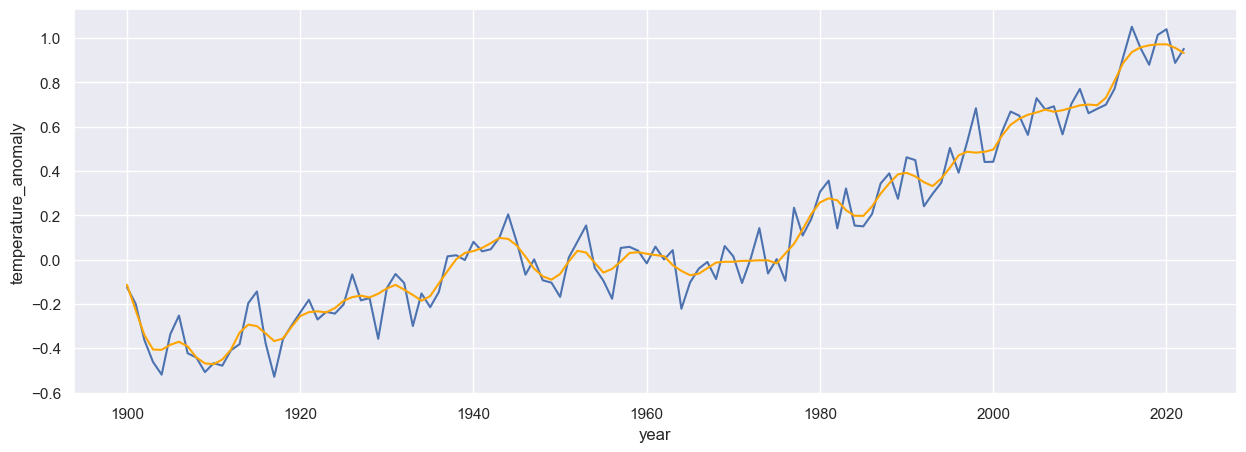

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global_yearly)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global_yearly, color="orange");

## Temperature trend per regions

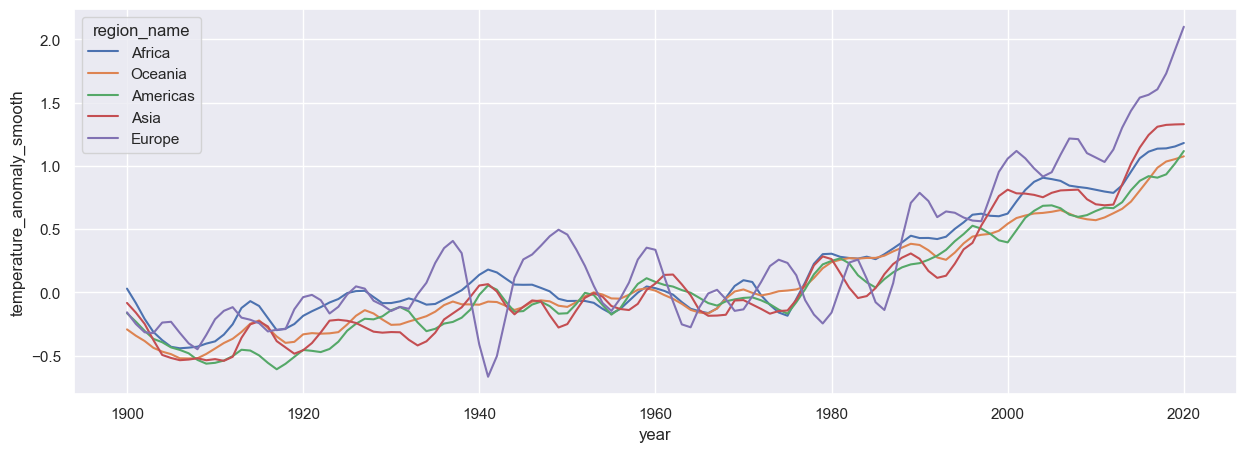

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year",y="temperature_anomaly_smooth",hue="region_name",data=temp_region_yearly, ax=ax);

=> Europe seems to be more extreme than the rest

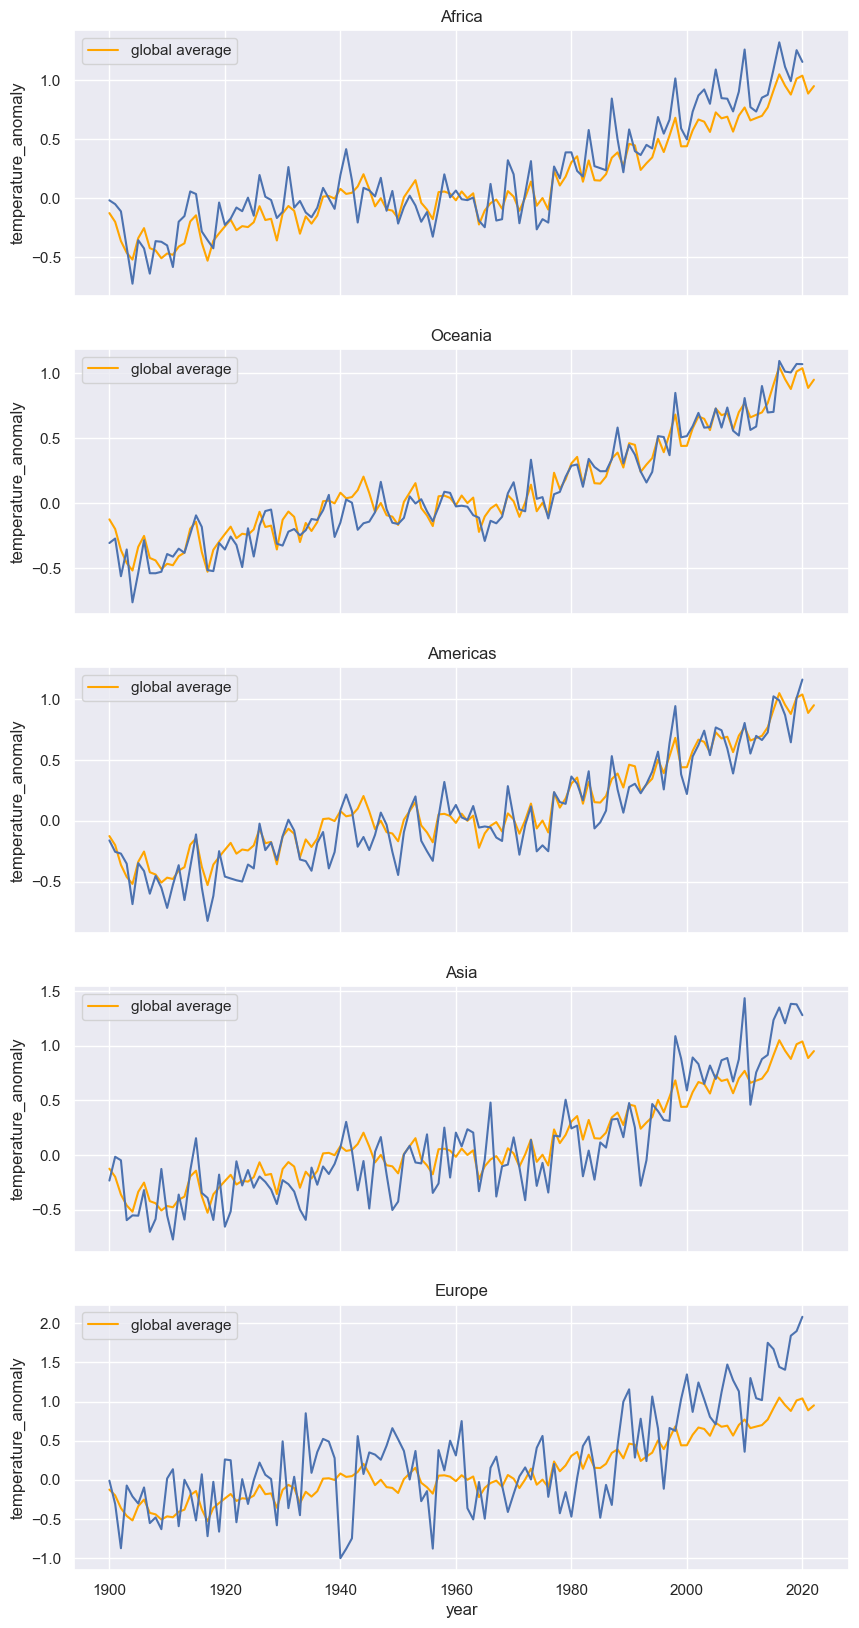

In [45]:
temp_regions = temp_region_yearly["region_name"].unique().tolist()
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 20))
for i, region in enumerate(temp_regions):
    sns.lineplot(x="year",y="temperature_anomaly",data=temp_global_yearly, ax=axes[i], color='orange', label="global average")
    sns.lineplot(x="year",y="temperature_anomaly",data=temp_region_yearly[temp_region_yearly["region_name"]==region], ax=axes[i])
    axes[i].set_title(region)
    axes[i].legend()

## Look at a single country (Austria)

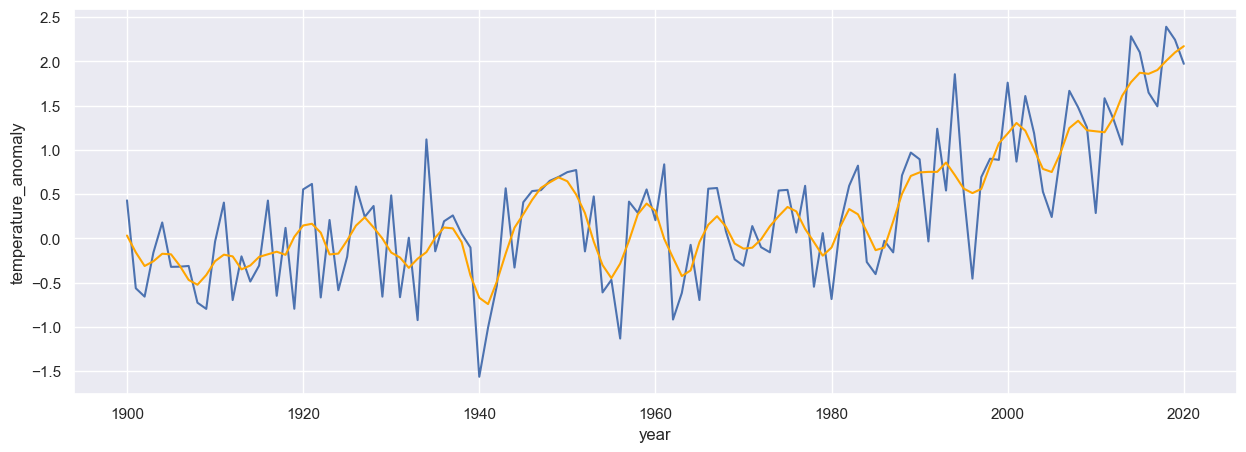

In [12]:
temp_aut = temp_country_yearly[temp_country_yearly["country_code"]=="AUT"]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year",y="temperature_anomaly",data=temp_aut, ax=ax)
sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_aut, ax=ax, color="orange");

## Are some Countries extremer than others?

In [42]:
temp_country_yearly[temp_country_yearly["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


In [43]:
temp_country_yearly[temp_country_yearly["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).tail()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27279,2020,SDN,0.528083,Sudan,0.595429
27136,2020,AFG,0.379750,Afghanistan,0.549394
27263,2020,PAK,0.531750,Pakistan,0.492607
27210,2020,IND,0.430750,India,0.485394
27260,2020,NPL,0.323667,Nepal,0.366796


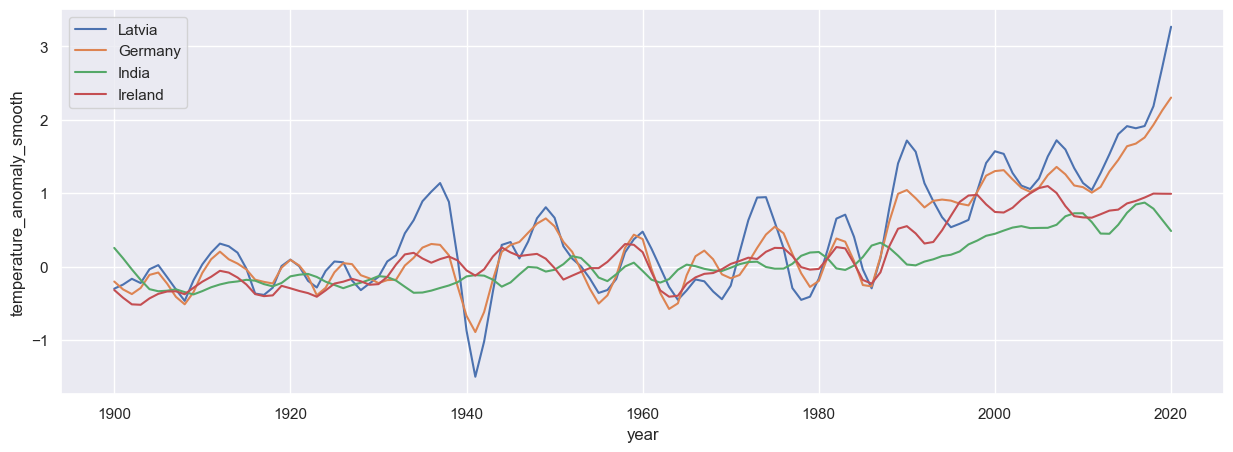

In [38]:
# choose countries that have large increase in temperature_anomaly, an some that have small increase
temp_extreme_countries = ["LVA","DEU","IND","IRL"]
fig, ax = plt.subplots(figsize=(15, 5))
for i,country_code in enumerate(temp_extreme_countries):
    temp_selected_country = temp_country_yearly[temp_country_yearly["country_code"]==country_code]
    selected_country_name = temp_selected_country["country_name"].iloc[0]
    sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
ax.legend();

## Can we see something if we apply linear regression per country?

In [75]:
temp_regression_countries = []
for country_code in temp_country_yearly["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country_yearly[temp_country_yearly["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


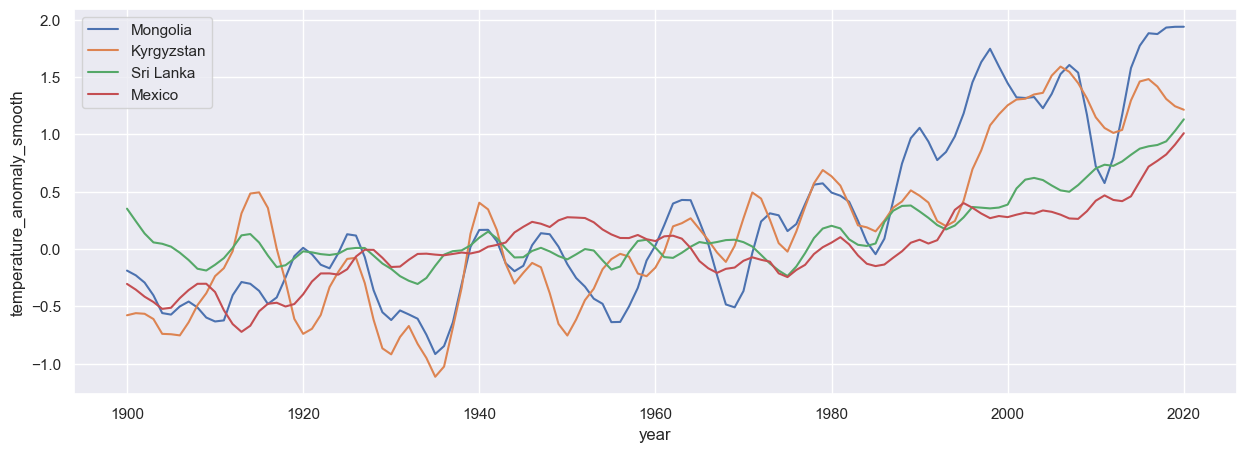

In [79]:
temp_extreme_countries = ["MNG","KGZ","LKA","MEX"]
fig, ax = plt.subplots(figsize=(15, 5))
for i,country_code in enumerate(temp_extreme_countries):
    temp_selected_country = temp_country_yearly[temp_country_yearly["country_code"]==country_code]
    selected_country_name = temp_selected_country["country_name"].iloc[0]
    sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
ax.legend();

=> cant really sea something meaningfull here